# CheckIt data augmentation - Autoencoder

An autoencoder comprises to two neural nets - encoder and decoder. The job of encoder is to transform the input data to a latent code. The dimension of this code is much less as compared to the dimension of the input data. This latent code is then passed to the decoder net, which maps it back to the input space. The loss function - at the end of the decoder - is the difference between the generated vector in input space and the original input vector. This constraint makes the encoder net function as a compressor, extracting out the most critical information from input and representing it in an efficient way, and decoder as a decompessor, which learns to map latent code to the original input.

### References

- [Keras Blog](https://blog.keras.io/building-autoencoders-in-keras.html)

In [12]:
import glob as glob
import cv2
import numpy as np

from keras.layers import Input, Dense
from keras.models import Model

# Read images from local dir
def load_normalized_data(data_dir):
    x_train = []
    x_test = [] 
    y_train = []
    y_test = []
    split = 0.8
    labels_to_fetch = ['1', '2', '3', '4']
    
    for curr_label in labels_to_fetch:        
        temp = []
        for image_path in glob.glob(data_dir+curr_label+'_*.jpg'):        
            #print(image_path)
            image = cv2.imread(image_path)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Flatten image
            #print(gray_image.shape)
            gray_image = np.reshape(gray_image, -1)
            #print(gray_image.shape)
            temp.append(gray_image)
        split_idx = int(len(temp) * split)
        np.random.shuffle(temp)
        x_train.extend(temp[:split_idx])
        y_train.extend([int(curr_label)] * len(temp[:split_idx]))
        x_test.extend(temp[split_idx:])
        y_train.extend([int(curr_label)] * len(temp[split_idx:]))
            
    x_train = (np.asarray(x_train, dtype=np.float32)) / 255.
    x_test = (np.asarray(x_test, dtype=np.float32)) / 255.
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_normalized_data(data_dir='../data/')

print(x_train.shape)
print(x_test.shape)

(2513, 2048)
(630, 2048)


In [10]:
# this is the size of our encoded representations
encoding_dim = 64  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(2048,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(2048, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 2513 samples, validate on 626 samples
Epoch 1/25
2513/2513 [==============================] - 1s - loss: 0.6388 - val_loss: 0.5903
Epoch 2/25
2513/2513 [==============================] - 0s - loss: 0.5830 - val_loss: 0.5816
Epoch 3/25
2513/2513 [==============================] - 0s - loss: 0.5796 - val_loss: 0.5810
Epoch 4/25
2513/2513 [==============================] - 0s - loss: 0.5791 - val_loss: 0.5805ss: 0.57
Epoch 5/25
2513/2513 [==============================] - 0s - loss: 0.5788 - val_loss: 0.5802
Epoch 6/25
2513/2513 [==============================] - 0s - loss: 0.5786 - val_loss: 0.5797
Epoch 7/25
2513/2513 [==============================] - 0s - loss: 0.5783 - val_loss: 0.5793
Epoch 8/25
2513/2513 [==============================] - 0s - loss: 0.5786 - val_loss: 0.5790
Epoch 9/25
2513/2513 [==============================] - 0s - loss: 0.5775 - val_loss: 0.5783
Epoch 10/25
2513/2513 [==============================] - 0s - loss: 0.5767 - val_loss: 0.5775
Epoch 11/25
25

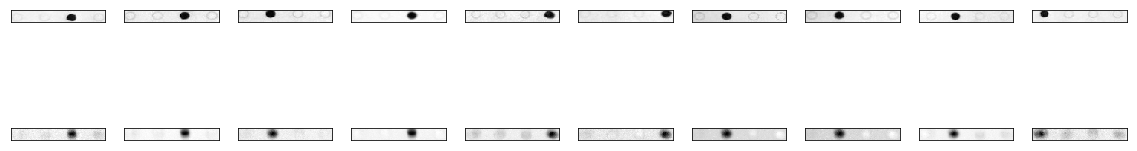

In [11]:
# encode and decode some digits
# note that we take them from the *test* set
np.random.shuffle(x_test)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(16, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(16, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()